In [28]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pytorch_msssim import ssim
from torch.cuda.amp import autocast, GradScaler
import time
import torch
import torch.optim as optim
from torch.amp import autocast, GradScaler



In [29]:
import os
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor()           # Convert to PyTorch tensor
])

# Dataset Path
dataset_path = "./data"

# CelebA default storage location
celeba_dir = os.path.join(dataset_path, "celeba")

# Check if dataset exists
if not os.path.exists(celeba_dir):
    print("Dataset not found. Downloading now...")
    download = True
else:
    print("Dataset already exists. Skipping download.")
    download = False

# Load Train and Validation Sets
train_dataset = torchvision.datasets.CelebA(root=dataset_path, split="train", download=download, transform=transform)
valid_dataset = torchvision.datasets.CelebA(root=dataset_path, split="valid", download=download, transform=transform)

# Batch size

batch_size = 128  


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)


# Print dataset sizes
print(f"Train Dataset Size: {len(train_dataset)} images")
print(f"Validation Dataset Size: {len(valid_dataset)} images")


Dataset already exists. Skipping download.
Train Dataset Size: 162770 images
Validation Dataset Size: 19867 images


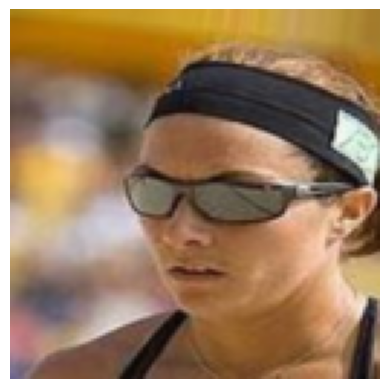

In [30]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))  # Convert tensor to NumPy format
    plt.imshow(img)
    plt.axis("off")
    plt.show()

# Get a batch of images
images, _ = next(iter(train_loader))

# Show the first image
imshow(images[0])


For removing pixels randomly

In [31]:
def remove_pixels(image, drop_prob=0.5, device="cpu"):
    """
    Randomly removes pixels from the input image by applying binary noise.
    
    Parameters:
        image (torch.Tensor): Input image tensor (C, H, W)
        drop_prob (float): Probability of a pixel being removed (set to 0)
        device (str): Device to run the operation on ("cpu" or "cuda")
    
    Returns:
        torch.Tensor: Noisy image with removed pixels
    """
    noise = (torch.rand_like(image, device=device) > drop_prob).float()  # Creates a mask
    image_noisy = image * noise  # Apply mask (sets some pixels to 0)
    
    return image_noisy

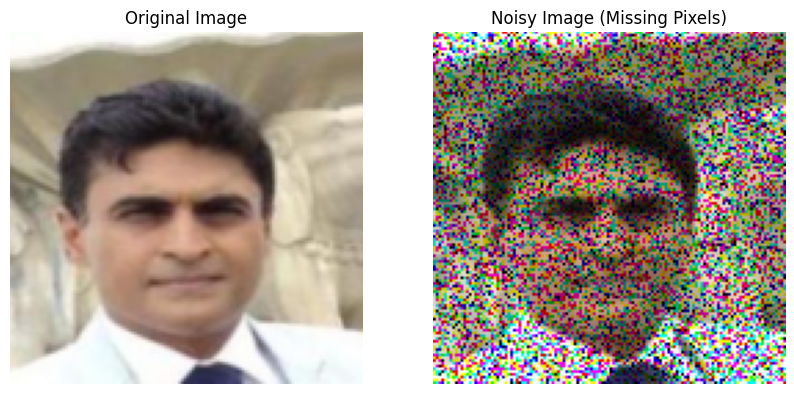

In [32]:
import matplotlib.pyplot as plt

# Get a batch of images from the DataLoader
images, _ = next(iter(train_loader))

# Select the first image from the batch
original_image = images[0]

# Apply noise (remove pixels)
noisy_image = remove_pixels(original_image, drop_prob=0.3)  # 30% of pixels removed

# Plot the images
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(original_image.permute(1, 2, 0))  # Convert (C, H, W) to (H, W, C)
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(noisy_image.permute(1, 2, 0))
ax[1].set_title("Noisy Image (Missing Pixels)")
ax[1].axis("off")

plt.show()


Defining the model

In [33]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),  # (64x64)
            nn.Tanh(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (32x32)
            nn.Tanh(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (16x16)
            nn.Tanh(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (8x8)
            nn.Tanh(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # (16x16)
            nn.Tanh(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # (32x32)
            nn.Tanh(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (64x64)
            nn.Tanh(),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),  # (128x128)
            nn.Sigmoid(),  # Ensure pixel values remain in [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize model
model = ConvAutoencoder()

Loss Function and Optimizer

In [34]:
from pytorch_msssim import ssim

def combined_loss(output, target):
    ssim_loss = 1 - ssim(output, target, data_range=1.0, size_average=True)
    l1_loss = nn.L1Loss()(output, target)
    return 0.8 * l1_loss + 0.2 * ssim_loss  # 80% L1, 20% SSIM

criterion = combined_loss  # Use this in training

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0003, betas=(0.5, 0.999), weight_decay=1e-5)




Saving and loading training checkpoints

In [35]:
import os

# Directory for saving models
checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Function to Save Model
def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    checkpoint = {
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "loss": loss
    }
    torch.save(checkpoint, os.path.join(checkpoint_dir, filename))
    print(f"Checkpoint saved at Epoch {epoch}")

# Function to Load Model
def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    checkpoint_path = os.path.join(checkpoint_dir, filename)
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint["model_state"])
        optimizer.load_state_dict(checkpoint["optimizer_state"])
        print(f"Checkpoint loaded from Epoch {checkpoint['epoch']}")
        return checkpoint["epoch"], checkpoint["loss"]
    else:
        print("No checkpoint found, starting from scratch.")
        return 0, float("inf")


Model Training

In [38]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Resume training if a checkpoint exists
start_epoch, best_loss = load_checkpoint(model, optimizer)

num_epochs = 20
save_every = 2  # Save model every X epochs

# Mixed Precision Training Setup
scaler = GradScaler("cuda")

for epoch in range(start_epoch, num_epochs):
    start_time = time.time()  # Measure epoch time
    model.train()
    total_loss = 0
    
    for images, _ in train_loader:
        images = images.to(device)

        # Apply Pixel Removal Noise
        noisy_images = remove_pixels(images, drop_prob=0.3, device=device)

        optimizer.zero_grad()
        
        #with autocast(device_type="cuda"): # Use mixed precision for faster training
        outputs = model(noisy_images)
        loss = criterion(outputs, images)  # Compare with original clean image

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    epoch_time = time.time() - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Time: {epoch_time:.2f}s")

    # Save Checkpoint Every Few Epochs
    if (epoch + 1) % save_every == 0:
        save_checkpoint(model, optimizer, epoch+1, avg_train_loss)

print("Training Complete!")


C:\Users\PC\AppData\Local\Temp\ipykernel_24056\4277334036.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded from Epoch 10
Epoch [11/20], Training Loss: 0.0641, Time: 38.10s
Epoch [12/20], Training Loss: 0.0626, Time: 38.00s
Checkpoint saved at Epoch 12
Epoch [13/20], Training Loss: 0.0611, Time: 38.23s
Epoch [14/20], Training Loss: 0.0596, Time: 38.32s
Checkpoint saved at Epoch 14
Epoch [15/20], Training Loss: 0.0583, Time: 38.58s
Epoch [16/20], Training Loss: 0.0570, Time: 38.48s
Checkpoint saved at Epoch 16
Epoch [17/20], Training Loss: 0.0556, Time: 39.15s
Epoch [18/20], Training Loss: 0.0540, Time: 38.70s
Checkpoint saved at Epoch 18
Epoch [19/20], Training Loss: 0.0515, Time: 38.45s
Epoch [20/20], Training Loss: 0.0491, Time: 38.30s
Checkpoint saved at Epoch 20
Training Complete!


Evaluating the model

In [40]:
import torch

# Function to evaluate model on validation set
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    total_loss = 0
    total_ssim = 0
    num_batches = len(dataloader)
    
    with torch.no_grad():  # Disable gradient computation
        for images, _ in dataloader:
            images = images.to(device)
            
            # Apply noise to images
            noisy_images = remove_pixels(images, drop_prob=0.3, device=device)

            # Pass through the autoencoder
            reconstructed_images = model(noisy_images)

            # Compute loss
            loss = criterion(reconstructed_images, images)
            total_loss += loss.item()

            # Compute SSIM score
            total_ssim += ssim(reconstructed_images, images, data_range=1.0, size_average=True).item()
    
    # Calculate average loss and SSIM
    avg_loss = total_loss / num_batches
    avg_ssim = total_ssim / num_batches

    print(f"Validation Loss: {avg_loss:.4f}")
    print(f"Validation SSIM Score: {avg_ssim:.4f}")

# Run evaluation
evaluate_model(model, valid_loader, criterion)


Validation Loss: 0.0487
Validation SSIM Score: 0.8695


Visualize reconstructions

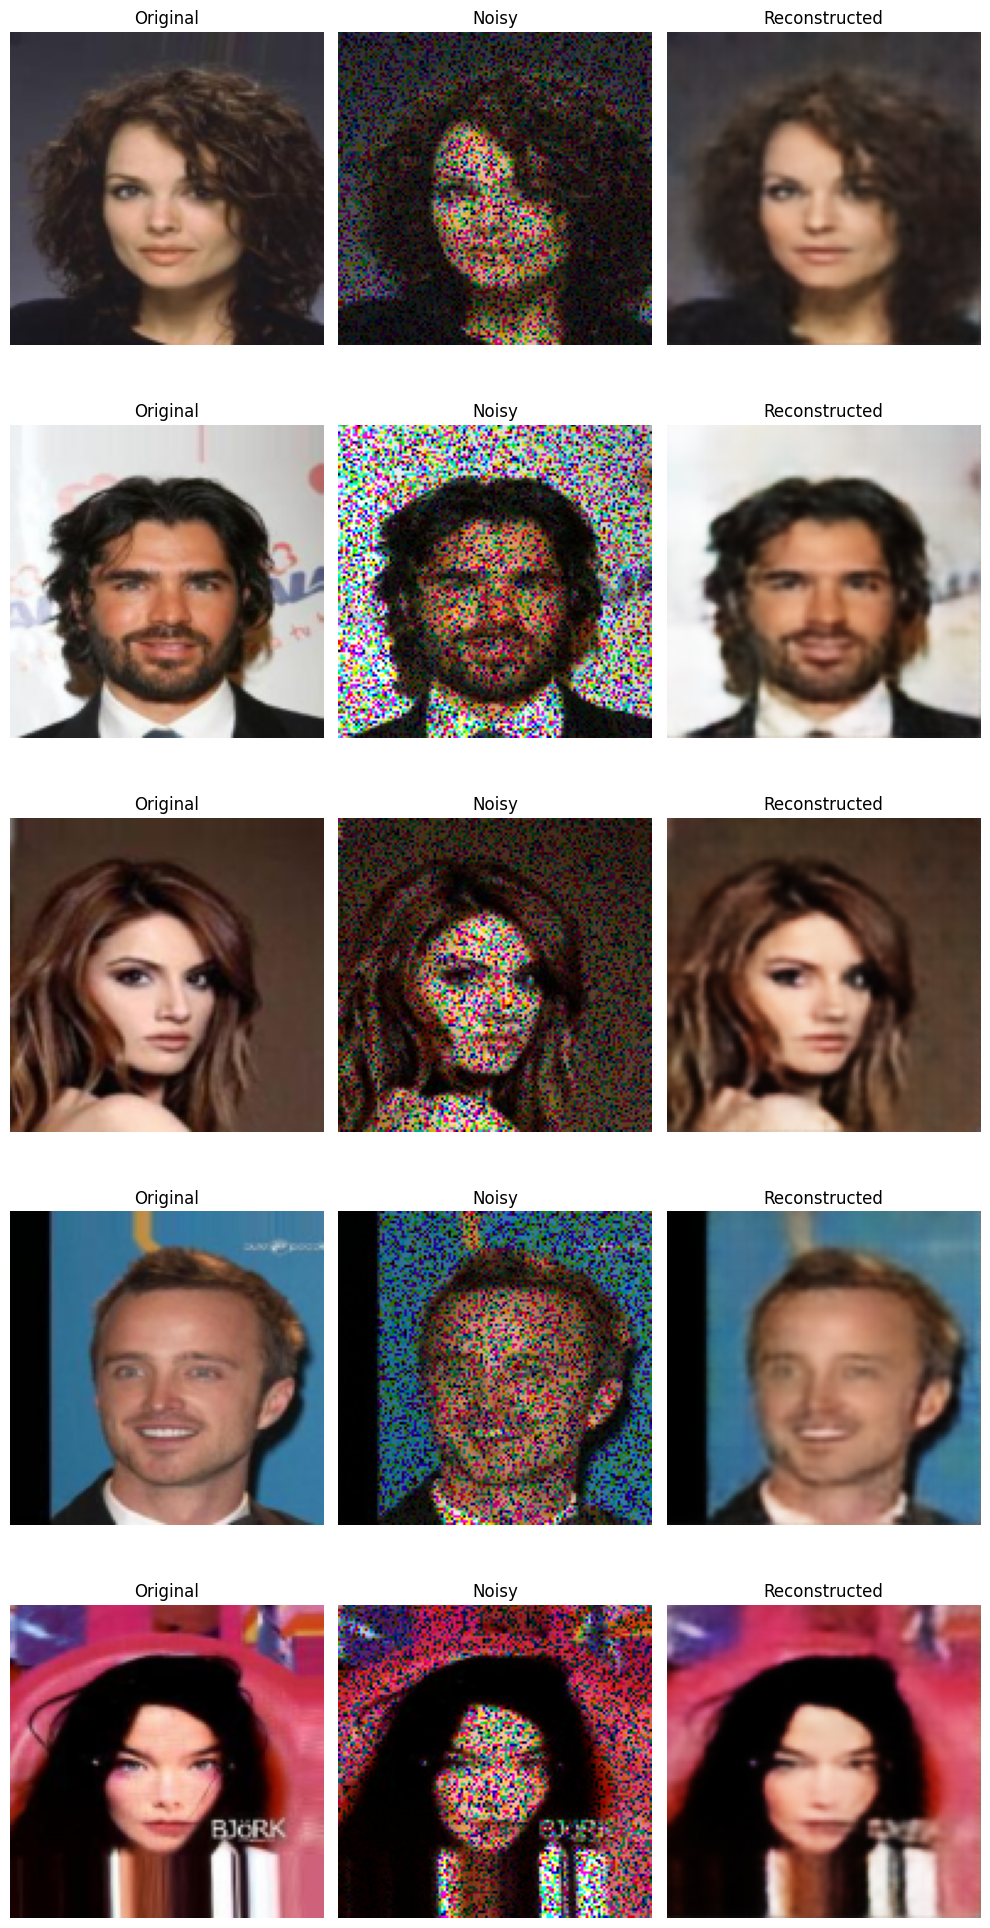

In [39]:
import matplotlib.pyplot as plt

# Function to visualize reconstructions
def visualize_reconstructions(model, dataloader, num_images=5, drop_prob=0.3):
    model.eval()  # Set model to evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Get a batch of validation images
    images, _ = next(iter(dataloader))
    images = images.to(device)

    # Create noisy images
    noisy_images = remove_pixels(images, drop_prob=drop_prob, device=device)

    # Pass noisy images through the autoencoder
    with torch.no_grad():
        reconstructed_images = model(noisy_images)

    # Convert tensors to CPU for visualization
    images = images.cpu()
    noisy_images = noisy_images.cpu()
    reconstructed_images = reconstructed_images.cpu()

    # Plot results
    fig, axes = plt.subplots(num_images, 3, figsize=(10, 4 * num_images))

    for i in range(num_images):
        axes[i, 0].imshow(images[i].permute(1, 2, 0))  # Original image
        axes[i, 0].set_title("Original")
        axes[i, 0].axis("off")

        axes[i, 1].imshow(noisy_images[i].permute(1, 2, 0))  # Noisy image
        axes[i, 1].set_title("Noisy")
        axes[i, 1].axis("off")

        axes[i, 2].imshow(reconstructed_images[i].permute(1, 2, 0))  # Reconstructed image
        axes[i, 2].set_title("Reconstructed")
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Run visualization
visualize_reconstructions(model, valid_loader, num_images=5, drop_prob=0.3)
